<a href="https://colab.research.google.com/github/vdlphm/CS403-Fall-2023/blob/main/hw7/hw7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 7 Cart-pole Dynamics Simulation**

The goal of HW 7 is to create a dynamics simulation of a cart-pole system described in the figure below. 

<img src="https://github.com/DARoSLab/CS403-Intro-Robotics/blob/main/hws/hw7/cart-pole.png?raw=true" width="450">

Use a generalized coordinate given in the figure. We give forward kinematics of important places of the system. 

\begin{align}
rA= \begin{pmatrix}
    x \\
    0 \\
    0
     \end{pmatrix},  &
\ rB = \begin{pmatrix}
    x + ccos(\theta)  \\
    csin(\theta) \\
    \theta
     \end{pmatrix} 
\\[10pt]
\implies vA= \begin{pmatrix}
    \dot{x} \\
    0 \\
    0
     \end{pmatrix}, &
\ vB = \begin{pmatrix}
    \dot{x} -c\dot{\theta}sin(\theta)  \\
    c\dot{\theta}cos(\theta) \\
    \dot{\theta}
     \end{pmatrix}
\\[10pt]
\implies aA= \begin{pmatrix}
    \ddot{x} \\
    0 \\
    0
     \end{pmatrix}, &
\ aB = \begin{pmatrix}
    \ddot{x} -c\ddot{\theta}sin(\theta)-c\dot{\theta}^2cos(\theta)  \\
    c\ddot{\theta}cos(\theta) - c\dot{\theta}^2sin(\theta) \\
    \ddot{\theta}
     \end{pmatrix}
\\[10pt]
\end{align}

In [76]:
import numpy as np 
import matplotlib.pyplot as plt 
import math 
import time 
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline

# **Q.1 Dynamics of a cart-pole system**

To make a dynamics simulation, we first need to complete the formula: 

$M \ddot{q} + b (q, \dot{q}) + g(q) = \begin{pmatrix} f \\ \tau \end{pmatrix} $.

Identify $M$, $b$, and $g$. Similar systems are used in the lecture and practice set. Please refer those. 


# Q.1.(a) [20 pts] Dynamics function 
Based on the given template code, complete the function returning the acceleration of the generalized coordinate: 

$\ddot{q} = \begin{pmatrix}
\ddot{x} \\ \ddot{\theta}
\end{pmatrix} = M^{-1}\left( u - b -g \right)$ 


In [77]:
def dynamics(q, u, params):
  m1, m2, I2, c, g = params
  x, th, xdot, thdot  = q.tolist()
  
  # Fill your code: define b (coriolis and centripetal), g (gravitational force), and M (mass matrix)
  b = np.array(
      [
      -m2 * c * pow(thdot, 2) * np.cos(th),
      0
      ])
  g = np.array(
      [
      0, 
      m2 * c * g * np.cos(th)
      ])
  M = np.array([
      [
          m1 + m2, 
       -m2 * c * np.sin(th)
       ], 
      [
          -m2 * c * np.sin(th), 
       I2 + m2 * pow(c, 2)
       ]])
  

  qddot = np.linalg.inv(M) @ np.subtract(np.subtract(u, b), g)
  return qddot

In [ ]:
# Test function: No need to change
def test_dynamics():
  m1 = 0.5
  m2 = 0.5
  I2 = 1
  c = 0.2
  g = 9.81
  dt = 0.005
  tf = 10.0
  params = [m1, m2, I2, c, g]
  test_cases = np.array([[0.0, np.pi/4, 0.0, 0.0],
                [0.5, -np.pi/4, 0.0, 0.0],
                [0.0, 0, 0.5, 0.0],
                [0.0, 0, 0.0, 5],
                ])
  soln = np.array([[-0.04832512, -0.68342045],
                   [ 0.04832512, -0.68342045],
                   [ 0.,         -0.96176471],
                   [ 2.5,        -0.96176471]])
  u = np.array([0, 0])
  res = np.zeros((4, 2))
  for i, q in enumerate(test_cases):
    res[i, :] = dynamics(q, u, params)
  assert np.allclose(res, soln), f"your dynamics implementation is not correct: your result {res} != solution: \n {soln}"
  print('Your implementation is correct!!')

In [ ]:
test_dynamics()

Your implementation is correct!!


# Q 1.1.(b) [15 pts] Dynamics simulation 

Complete the following function that finds state trajectory by using dynamics function we found in Q.1.1.(a). 

In [85]:
def simulate_cartpole(x0, params, tf=1.0, dt=0.01):
  m1, m2, I2, c, g = params
  num_step = int(np.floor(tf/dt));
  tspan = np.linspace(0, tf, num_step); 
  x_out = np.zeros((4,num_step));
  x_out[:,0] = x0;

  q = x_out[:,0]
  for i in range(num_step-1):
      u = np.zeros(2).T # put zero since there is no motor input for Q.1.

      # Fill your code: update the sequence of state (x_out) by utilizing the dynamcs function
      # Hint: use semi-implicit Euler integration
      qddot = dynamics(x_out[:, i - 1], u, params)
      x_out[0, i] = q[0] + qddot[0] * pow(dt, 2)
      x_out[1, i] = q[1] + qddot[1] * pow(dt, 2) 
      x_out[2, i] = q[2] + qddot[0] * dt
      x_out[3, i] = q[3] + qddot[1] * dt
      q = x_out[:, i]
  
  return x_out

In [83]:
# Use the given parameters: No need to change
m1 = 0.5
m2 = 0.5
I2 = 1
c = 0.2
g = 9.81
dt = 0.05
tf = 10.0
params = [m1, m2, I2, c, g]


In [86]:
# Cart-Pole visualization function: No need to change
def visualize_cartpole(q_hist, params=[0.4, 0.4, 0.01], num_frames=100):
  fig= plt.figure(figsize=(10,10))
  ax = plt.subplot(1,1,1)   
  c_l, p_l, dt = params
  cart, = ax.plot([-0.5*c_l, 0.5*c_l], [0, 0], 'b', lw=10)
  pole, = ax.plot([0, 0], [0, p_l], 'r', lw=10)
  
  txt_title = ax.set_title('')
  
  ax.set_xlim(( -1, 1))            
  ax.set_ylim((-0.7, 1.3))
  txt_title = ax.set_title('')
  interval = len(q_hist)//num_frames
  def drawFrame(k):
    k = interval*k
    x, theta = q_hist[k]

    rA = [x, 0]
    rC = [x + p_l*np.cos(theta), p_l*np.sin(theta)]
    cart.set_data([x-0.5*c_l, x+0.5*c_l], [0, 0])
    pole.set_data([rA[0], rC[0]], [rA[1], rC[1]])
    txt_title.set_text(f't = {dt*k:.2f} sec')
    return cart, pole
  anim = animation.FuncAnimation(fig, drawFrame, frames=num_frames, interval=interval, blit=True)
  return anim


In [ ]:
# Simulation and animation code: No need to change
x0 = np.array([0.0, np.pi/4, 0.0, 0.0]).T;
x_out = simulate_cartpole(x0, params, tf=tf, dt=dt)
anim = visualize_cartpole(x_out[:2, :].T, num_frames=50)
plt.close()
HTML(anim.to_html5_video())

# Q.1.(c) [15 pts] Kinetic and Potential Energy

Plot the kinetic, potential, and total energy of the system. 

Hint: use the equation, $T = \frac{1}{2} \dot{q}^{\top}M\dot{q}$, for kinetic energy computation.

In [ ]:
def kinetic_energy(q, params):
  m1, m2, I2, c, g = params

  # Fill your code: complete the function return the profile of kinetic energy
  T = (m1 * pow(q[2], 2) + 
       m2 * (pow(q[2], 2) + 2 * q[2] * q[3] * c * np.cos(q[1])) + 
       I2 * pow(q[3], 2))/2
  return T

def potential_energy(q, params):
  m1, m2, I2, c, g = params

  # Fill your code: complete the function return the profile of kinetic energy
  P = m2 * g * c * np.sin(q[1])
  return P

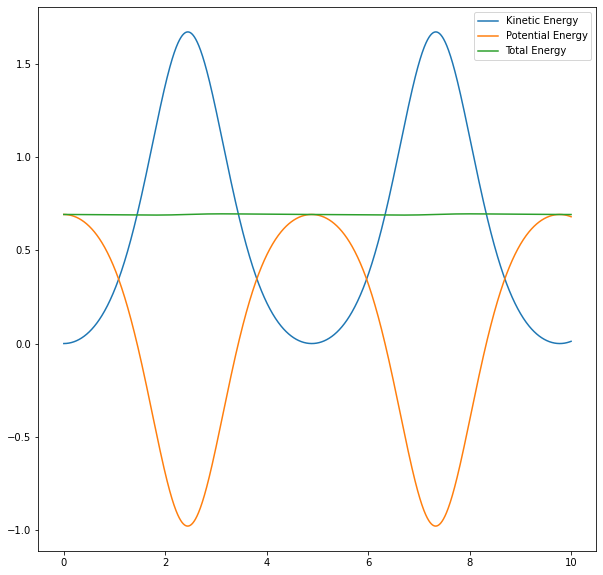

In [ ]:
# Kinematic, potential, and total energy plot: No need to change
ke_hist = np.zeros(x_out.shape[1])
pe_hist = np.zeros(x_out.shape[1])
ts = np.arange(0, tf, dt)

for i, x in enumerate(x_out.T):
  ke_hist[i] = kinetic_energy(x, params)
  pe_hist[i] = potential_energy(x, params)

fig= plt.figure(figsize=(10,10))
plt.plot(ts, ke_hist, label='Kinetic Energy')
plt.plot(ts, pe_hist, label='Potential Energy')
plt.plot(ts, pe_hist+ke_hist, label='Total Energy')
plt.legend()
plt.show()

# Q.1.(d) [10 pts] Energy profile analysis

Explain the meaning of energy profiles by correlating them with the system's behavior.


Your answer: Since there is no outside force acting on our system, its total energy stays constant which results in a horizontal line in total energy. And this total energy is divided to kinetic and potential energy. That's why when kinetic increases, potential decreases. The peaks in potential are related to when the arm swings to its maximum height and those are also positions where the system change its direction resulting in kinetic energy to be zero. And when the arm is in its lowest position, we have potential to be minimum and the system is moving with maximum speed.

# **Q.2. The effect of damping** 

Now, let's consider the case when actuators operate like dampers. The first prismatic joint resists the joint motion with viscous friction efficiency of 0.5. Therefore, the formulation will be $f = -0.5\  \dot{x}$. For the second revolute joint, we will make the same viscous friction but with a coefficient of 10. Therefore, the formula is $\tau = -10\  \dot{\theta}$.  


# Q.2.(a) [15 pts] Dynamics simulation of the cart-pole with the dampers.

Complete the dynamics simulation code of the cart-pole system with the dampings explained above. 

In [ ]:
def simulate_cartpole_damping(x0, params, tf=1.0, dt=0.01):
  m1, m2, I2, c, g = params
  num_step = int(np.floor(tf/dt));
  tspan = np.linspace(0, tf, num_step); 
  x_out = np.zeros((4,num_step));
  x_out[:,0] = x0;

  for i in range(num_step-1):
      # Fill your code: define the proper force and torque input 
      u = ...

      # Fill your code: update the sequence of state (x_out) by utilizing the dynamcs function
      # Hint: use semi-implicit Euler integration
      qddot = dynamics(x_out[:, i - 1], u, params)
      x_out[0, i] = q[0] + qddot[0] * pow(dt, 2)
      x_out[1, i] = q[1] + qddot[1] * pow(dt, 2) 
      x_out[2, i] = q[2] + qddot[0] * dt
      x_out[3, i] = q[3] + qddot[1] * dt
      q = x_out[:, i]
  
  return x_out

In [ ]:
x0 = np.array([0.0, np.pi/4, 0.0, 0.0]).T;
x_out_damped = simulate_cartpole_damping(x0, params, tf=tf, dt=dt)
anim = visualize_cartpole(x_out_damped[:2, :].T, num_frames=50)
plt.close()
HTML(anim.to_html5_video())

# Q.2.(b) [15 pts] Energy plot

Plot the kinetic, potential, and total energy of system by refering the codes in Q.1.(c). 

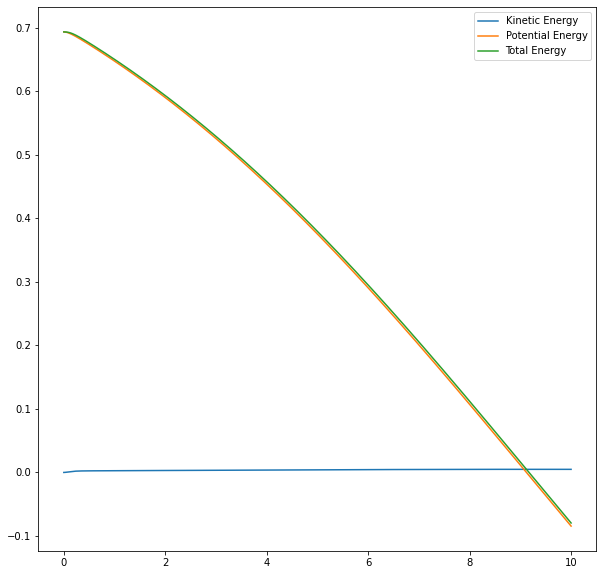

In [ ]:
ke_hist = np.zeros(x_out_damped.shape[1])
pe_hist = np.zeros(x_out_damped.shape[1])
ts = np.arange(0, tf, dt)

# Fill our your code: 
for i, x in enumerate(x_out.T):
  ke_hist[i] = kinetic_energy(x, params)
  pe_hist[i] = potential_energy(x, params)

fig= plt.figure(figsize=(10,10))
plt.plot(ts, ke_hist, label='Kinetic Energy')
plt.plot(ts, pe_hist, label='Potential Energy')
plt.plot(ts, pe_hist+ke_hist, label='Total Energy')
plt.legend()
plt.show()

# Q.2.(c) [10 pts] Energy profile analysis

Explain the meaning of energy profiles by correlating them with the system's behavior and the previous non-damping case.


Your answer: Since we have friction in our system, the rotation of arm is countered by friction which cause the cart only have slight velocity.